Prepare ShapeNet Data:
Download ShapeNet point clouds or convert from meshes using tools like trimesh
Save each point cloud as a .npy file in a structured directory

Training:
Update "path_to_shapenet_point_clouds" in the dataset initialization
Run train_point_cloud_gan()
Monitor losses and visualize generated samples

Generation:
After training, load the generator:
////
generator = Generator().to(device)
generator.load_state_dict(torch.load("generator.pth"))
Generate new point clouds:
///
z = torch.randn(1, latent_dim).to(device)
new_pc = generator(z).cpu().numpy()[0]
visualize_point_cloud(new_pc)

---

Imports and Setup

In [35]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import open3d as o3d
import torch.nn as nn
import traceback
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

In [46]:
pip install POT

     -------------------------------------- 348.4/348.4 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Database conversion
The original dataset contains files in .off file format, which is incompatible with the subsequent code.\
This chunk of code converts them into .npy file format, compatible with the subsequent code.

Gloabl Variables

In [ ]:
# Global variables
generator = None
latent_dim = None

Utility Functions 

In [36]:
def save_point_cloud(points, filename):
    """ Save point cloud to PLY file """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.io.write_point_cloud(filename, pcd)

def visualize_point_cloud(points):
    """ Interactive visualization """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])

Dataset Class

In [37]:
class PointCloudDataset(Dataset):
    def __init__(self, root_dir, num_points=2048, split='train'):
        self.root_dir = root_dir
        self.num_points = num_points
        self.files = []
        
        if not os.path.exists(root_dir):
            raise ValueError(f"Directory {root_dir} does not exist")
            
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith('.npy'):
                        self.files.append(os.path.join(class_path, file))
        
        if len(self.files) == 0:
            raise ValueError(f"No .npy files found in {root_dir}")

        split_idx = int(0.8 * len(self.files))
        self.files = self.files[:split_idx] if split == 'train' else self.files[split_idx:]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            pc = np.load(self.files[idx], allow_pickle=True)

            if pc.shape[0] > self.num_points:
                idxs = np.random.choice(pc.shape[0], self.num_points, replace=False)
                pc = pc[idxs]
            elif pc.shape[0] < self.num_points:
                idxs = np.random.choice(pc.shape[0], self.num_points, replace=True)
                pc = pc[idxs]

            pc = torch.from_numpy(pc).float()
            pc = self.normalize_point_cloud(pc)
            return pc

        except Exception as e:
            print(f"Error loading index {idx}, file: {self.files[idx]}")
            print(f"Exception: {e}")
            return torch.zeros((self.num_points, 3))  # or raise the error again 

    def normalize_point_cloud(self, pc):
        """ Normalize point cloud to fit in [-1, 1] cube """
        centroid = torch.mean(pc, dim=0)
        pc = pc - centroid
        max_dist = torch.max(torch.sqrt(torch.sum(pc**2, dim=1)))
        pc = pc / max_dist
        return pc

Model Definitions 

In [38]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_points):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_points = num_points
        
        # Fully connected layers with batch norm and leaky ReLU
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            
            # Final layer outputs 3D coordinates (x,y,z) for each point
            nn.Linear(2048, num_points * 3),
            nn.Tanh()  # Tanh keeps outputs in [-1,1] range
        )

    def forward(self, z):
        batch_size = z.size(0)
        # Generate point cloud
        pc = self.model(z)
        # Reshape to [batch_size, num_points, 3]
        pc = pc.view(batch_size, self.num_points, 3)
        return pc

class Discriminator(nn.Module):
    def __init__(self, num_points=2048):
        super(Discriminator, self).__init__()
        self.num_points = num_points
        
        # Shared MLP layers (similar to PointNet)
        self.conv1 = nn.Conv1d(3, 64, 1)  # Input channels: 3 (x,y,z), output: 64
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        # Global feature layer
        self.global_conv = nn.Conv1d(256, 512, 1)
        self.global_bn = nn.BatchNorm1d(512)
        
        # Classification layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x shape: (batch_size, num_points, 3)
        x = x.transpose(2, 1)  # Convert to (batch_size, 3, num_points)
        
        # Shared MLP
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        
        # Global features
        x = self.relu(self.global_bn(self.global_conv(x)))
        x = torch.max(x, 2, keepdim=True)[0]  # Global max pooling
        x = x.view(-1, 512)
        
        # Classification
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

Training Utilities

In [39]:
def gradient_penalty(discriminator, real_samples, fake_samples, device):
    """ Calculates the gradient penalty loss for WGAN-GP """
    batch_size = real_samples.size(0)
    # Random weight term for interpolation
    alpha = torch.rand(batch_size, 1, 1).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(batch_size, 1).to(device)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

Evaluation Metrics

In [40]:
def chamfer_distance(pc1, pc2):
    """Compute Chamfer Distance between two point clouds"""
    dist = cdist(pc1, pc2)
    return np.mean(np.min(dist, axis=0)) + np.mean(np.min(dist, axis=1))

def earth_movers_distance(pc1, pc2):
    """Approximate EMD using the Sinkhorn algorithm"""
    from ot import emd
    # Normalize to probability distributions
    pc1 = pc1 / np.sum(pc1, axis=1, keepdims=True)
    pc2 = pc2 / np.sum(pc2, axis=1, keepdims=True)
    cost_matrix = cdist(pc1, pc2)
    return emd([], [], cost_matrix)

def evaluate_model(generator, latent_dim, real_dataset, num_samples=100, device='cuda'):
    """Comprehensive evaluation of generated samples"""
    generator.eval()
    
    # Generate samples
    fake_pcs = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            fake_pc = generator(z).cpu().numpy()[0]
            fake_pcs.append(fake_pc)
    
    # Get real samples
    real_pcs = [real_dataset[i].numpy() for i in range(num_samples)]
    
    # Compute metrics
    cd_scores, emd_scores = [], []
    for real_pc, fake_pc in zip(real_pcs, fake_pcs):
        cd_scores.append(chamfer_distance(real_pc, fake_pc))
        emd_scores.append(earth_movers_distance(real_pc, fake_pc))
    
    return {
        'chamfer_distance': np.mean(cd_scores),
        'earth_movers_distance': np.mean(emd_scores),
        'samples': (real_pcs, fake_pcs)
    }

Visualization Functions

In [41]:
def visualize_comparison(real_pc, fake_pc, save_path=None):
    """Visualize real vs generated point clouds side by side"""
    fig = plt.figure(figsize=(12, 6))
    
    # Real point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(real_pc[:,0], real_pc[:,1], real_pc[:,2], s=1)
    ax1.set_title('Real Point Cloud')
    ax1.set_axis_off()
    
    # Generated point cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(fake_pc[:,0], fake_pc[:,1], fake_pc[:,2], s=1)
    ax2.set_title('Generated Point Cloud')
    ax2.set_axis_off()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

def generate_and_save_samples(generator, latent_dim, num_samples=5, device='cuda'):
    """Generate and save sample point clouds"""
    generator.eval()
    os.makedirs('samples', exist_ok=True)
    
    with torch.no_grad():
        for i in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            pc = generator(z).cpu().numpy()[0]
            
            # Save as PLY and PNG
            save_path = f'samples/sample_{i}'
            save_point_cloud(pc, f'{save_path}.ply')
            
            # Create visualization
            fig = plt.figure(figsize=(6,6))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=1)
            ax.set_axis_off()
            plt.savefig(f'{save_path}.png', bbox_inches='tight', dpi=150)
            plt.close()

Post-Training Analysis Script


In [ ]:
def analyze_results(generator, latent_dim, run_dir='results'):
    """Analyze and visualize training results"""
    # 1. Plot training curves (would need to modify to log losses)
    # plot_training_curves(run_dir)
    
    # 2. Create interpolation video
    create_interpolation_video(generator, latent_dim)
    
    # 3. Create HTML visualization
    generate_html_viewer(run_dir)

def plot_training_curves(run_dir):
    """Plot loss and metric curves"""
    # Implement reading from log files and plotting
    pass

def create_interpolation_video(generator, latent_dim, num_frames=60):
    """Create interpolation between random points in latent space"""
    z1 = torch.randn(1, latent_dim)
    z2 = torch.randn(1, latent_dim)
    
    os.makedirs('interpolation', exist_ok=True)
    
    for i in range(num_frames):
        alpha = i / num_frames
        z = alpha * z1 + (1-alpha) * z2
        pc = generator(z).cpu().numpy()[0]
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=1)
        plt.savefig(f'interpolation/frame_{i:03d}.png')
        plt.close()
    
    # Use ffmpeg to create video
    os.system('ffmpeg -r 30 -i interpolation/frame_%03d.png -vcodec libx264 -crf 25 interpolation.mp4')

 Enhanced Evaluation Metrics Implementation

In [43]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

def chamfer_distance(pc1, pc2):
    """Compute Chamfer Distance between two point clouds"""
    dist = cdist(pc1, pc2)
    return np.mean(np.min(dist, axis=0)) + np.mean(np.min(dist, axis=1))

def earth_movers_distance(pc1, pc2):
    """Approximate EMD using the Sinkhorn algorithm"""
    from ot import emd
    # Normalize to probability distributions
    pc1 = pc1 / np.sum(pc1, axis=1, keepdims=True)
    pc2 = pc2 / np.sum(pc2, axis=1, keepdims=True)
    cost_matrix = cdist(pc1, pc2)
    return emd([], [], cost_matrix)

def evaluate_model(generator, latent_dim, real_dataset, num_samples=100, device='cuda'):
    """Comprehensive evaluation of generated samples"""
    generator.eval()
    
    # Generate samples
    fake_pcs = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            fake_pc = generator(z).cpu().numpy()[0]
            fake_pcs.append(fake_pc)
    
    # Get real samples
    real_pcs = [real_dataset[i].numpy() for i in range(num_samples)]
    
    # Compute metrics
    cd_scores, emd_scores = [], []
    for real_pc, fake_pc in zip(real_pcs, fake_pcs):
        cd_scores.append(chamfer_distance(real_pc, fake_pc))
        emd_scores.append(earth_movers_distance(real_pc, fake_pc))
    
    return {
        'chamfer_distance': np.mean(cd_scores),
        'earth_movers_distance': np.mean(emd_scores),
        'samples': (real_pcs, fake_pcs)
    }

Training Function

In [ ]:
def train_point_cloud_gan():
    global global_generator, global_latent_dim 
    # Hyperparameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_latent_dim = 62  
    num_points = 2048
    batch_size = 32
    epochs = 16
    lr = 0.0005
    n_critic = 3
    lambda_gp = 7
    
    # Debug setup
    import gc
    def print_memory():
        if torch.cuda.is_available():
            print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.memory_reserved()/1e9:.2f}GB")
        gc.collect()

    # Create dataset and dataloader
    try:
        dataset = PointCloudDataset("C:/Users/ertat/Downloads/chair", num_points=num_points)
        eval_dataset = PointCloudDataset("C:/Users/ertat/Downloads/chair", num_points=num_points, split='test')
        print(f"Dataset loaded with {len(dataset)} samples (train), {len(eval_dataset)} samples (test)")

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        print(f"Dataloader created with {len(dataloader)} batches of size {batch_size}")
    except Exception as e:
        print(f"Error initializing data: {e}")
        return

    # Initialize networks
    global_generator = Generator(global_latent_dim, num_points).to(device)
    discriminator = Discriminator(num_points).to(device)
    global_generator.train()
    discriminator.train()

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Training loop with enhanced monitoring
    try:
        for epoch in range(epochs):
            print(f"\n--- Starting Epoch {epoch+1}/{epochs} ---")
            print_memory()
            
            for i, real_pcs in enumerate(tqdm(dataloader)):
                # Skip any problematic batches
                if real_pcs.size(0) != batch_size:
                    print(f"\nSkipping incomplete batch of size {real_pcs.size(0)}")
                    continue
                    
                real_pcs = real_pcs.to(device)
                
                # Train Discriminator
                optimizer_D.zero_grad()
                
                # Generate fake point clouds
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_pcs = generator(z)
                
                # Real and fake losses
                real_loss = -torch.mean(discriminator(real_pcs))
                fake_loss = torch.mean(discriminator(fake_pcs.detach()))
                
                # Gradient penalty
                gp = gradient_penalty(discriminator, real_pcs.data, fake_pcs.data, device)
                
                # Total discriminator loss
                d_loss = real_loss + fake_loss + lambda_gp * gp
                d_loss.backward()
                optimizer_D.step()
                
                # Train Generator every n_critic steps
                if i % n_critic == 0:
                    optimizer_G.zero_grad()
                    z = torch.randn(batch_size, latent_dim).to(device)
                    fake_pcs = generator(z)
                    g_loss = -torch.mean(discriminator(fake_pcs))
                    g_loss.backward()
                    optimizer_G.step()
                
                # Memory monitoring
                if i % 10 == 0:
                    print_memory()
                    torch.cuda.synchronize()  # Ensure CUDA ops complete
            
            # Epoch summary
            print(f"[Epoch {epoch}/{epochs}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")
            
            # Evaluation and visualization every 5 epochs
            if epoch % 5 == 0 or epoch == epochs - 1:
                # Save checkpoint
                torch.save({
                    'epoch': epoch,
                    'generator': generator.state_dict(),
                    'discriminator': discriminator.state_dict(),
                    'optimizer_G': optimizer_G.state_dict(),
                    'optimizer_D': optimizer_D.state_dict(),
                }, f"checkpoint_epoch_{epoch}.pth")
                print(f"Saved checkpoint at epoch {epoch}")
                
                # Evaluation
                metrics = evaluate_model(generator, latent_dim, eval_dataset, 
                                      num_samples=50, device=device)
                
                print(f"\nEpoch {epoch} Evaluation:")
                print(f"Chamfer Distance: {metrics['chamfer_distance']:.4f}")
                print(f"Earth Movers Distance: {metrics['earth_movers_distance']:.4f}")
                
                # Visualize samples
                real_sample, fake_sample = metrics['samples'][0][0], metrics['samples'][1][0]
                visualize_comparison(real_sample, fake_sample, 
                                   save_path=f"results/epoch_{epoch}_comparison.png")
                
                # Save samples
                generate_and_save_samples(generator, latent_dim, num_samples=5, device=device)
                
    except torch.cuda.OutOfMemoryError:
        print("\nCUDA out of memory! Try:")
        print(f"- Reducing batch size (currently {batch_size})")
        print(f"- Using fewer points (currently {num_points})")
        return
    except Exception as e:
        print(f"\nTraining interrupted by {type(e).__name__}: {str(e)}")
        traceback.print_exc()
        return

    # Final sample generation and analysis
    try:
        with torch.no_grad():
            global_generator.eval()
            # Save final sample
            sample_z = torch.randn(1, global_latent_dim).to(device)
            sample_pc = global_generator(sample_z).cpu().numpy()
            save_point_cloud(sample_pc[0], "final_sample.ply")
            print("Saved final sample")
            
            # Generate analysis - now using global variables
            analyze_results(global_generator, global_latent_dim)
            
    except Exception as e:
        print(f"Error in final generation: {e}")

    print("\nTraining completed successfully!")

Main Execution Block

Dataset loaded with 791 samples (train), 198 samples (test)
Dataloader created with 24 batches of size 32

--- Starting Epoch 1/16 ---
GPU Memory: 0.34GB / 0.42GB


  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

GPU Memory: 0.53GB / 3.05GB


 46%|████▌     | 11/24 [00:03<00:03,  3.27it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:06<00:00,  3.09it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


[Epoch 0/16] D loss: 0.5625, G loss: -0.4229
Saved checkpoint at epoch 0

Epoch 0 Evaluation:
Chamfer Distance: 0.4361
Earth Movers Distance: 0.0000


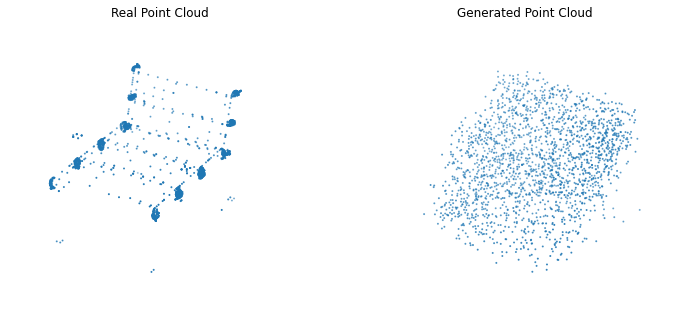


--- Starting Epoch 2/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:14,  1.62it/s]

GPU Memory: 0.53GB / 3.32GB


 50%|█████     | 12/24 [00:04<00:03,  3.57it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:07<00:01,  2.77it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:08<00:00,  2.91it/s]


[Epoch 1/16] D loss: -0.0581, G loss: -0.3956

--- Starting Epoch 3/16 ---
GPU Memory: 0.53GB / 3.32GB


  8%|▊         | 2/24 [00:00<00:05,  3.91it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:03<00:04,  3.10it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:06<00:01,  3.00it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


[Epoch 2/16] D loss: -0.0693, G loss: -0.7863

--- Starting Epoch 4/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:10,  2.21it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:03<00:03,  3.26it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:06<00:00,  3.36it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


[Epoch 3/16] D loss: 0.0531, G loss: -0.4346

--- Starting Epoch 5/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:10,  2.22it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:03<00:03,  3.26it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:06<00:00,  3.40it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


[Epoch 4/16] D loss: 2.2406, G loss: -0.8335

--- Starting Epoch 6/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:10,  2.23it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:03<00:03,  3.27it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:06<00:00,  3.41it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


[Epoch 5/16] D loss: -0.2170, G loss: -0.4409
Saved checkpoint at epoch 5

Epoch 5 Evaluation:
Chamfer Distance: 0.2934
Earth Movers Distance: 0.0000


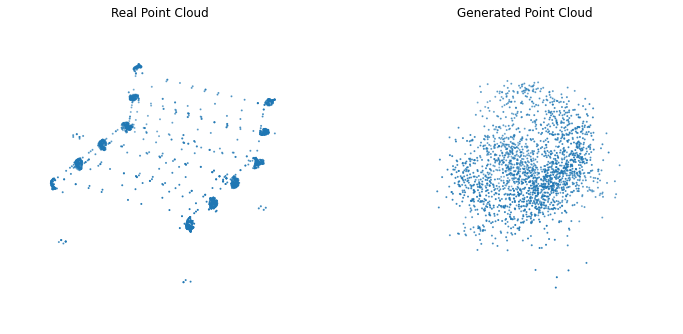


--- Starting Epoch 7/16 ---
GPU Memory: 0.53GB / 3.32GB


  8%|▊         | 2/24 [00:00<00:05,  3.92it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:03,  3.76it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:05<00:00,  4.08it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.17it/s]


[Epoch 6/16] D loss: -0.2359, G loss: -0.3985

--- Starting Epoch 8/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:11,  2.09it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:03,  4.14it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:04<00:00,  4.19it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.44it/s]


[Epoch 7/16] D loss: -0.1600, G loss: -0.2558

--- Starting Epoch 9/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:08,  2.65it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:03,  4.05it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:04<00:00,  4.13it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.43it/s]


[Epoch 8/16] D loss: -0.2640, G loss: -0.4039

--- Starting Epoch 10/16 ---
GPU Memory: 0.53GB / 3.32GB


  8%|▊         | 2/24 [00:00<00:05,  4.31it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:03,  3.78it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:05<00:00,  4.12it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


[Epoch 9/16] D loss: -0.1926, G loss: -0.5159

--- Starting Epoch 11/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:08,  2.72it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:03,  4.05it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:04<00:00,  4.45it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.58it/s]


[Epoch 10/16] D loss: -0.2016, G loss: -0.4009
Saved checkpoint at epoch 10

Epoch 10 Evaluation:
Chamfer Distance: 0.2999
Earth Movers Distance: 0.0000


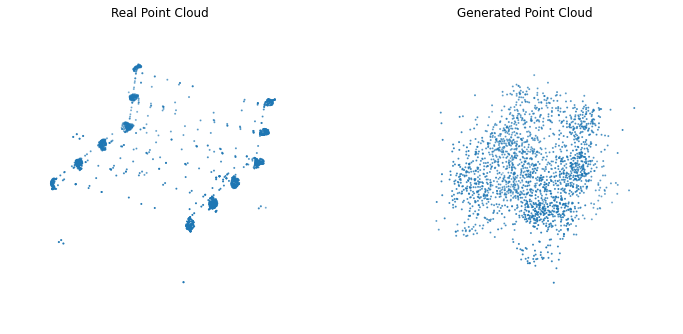


--- Starting Epoch 12/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:09,  2.38it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:03,  4.28it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:04<00:00,  4.13it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.44it/s]


[Epoch 11/16] D loss: 1.1797, G loss: -0.4937

--- Starting Epoch 13/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:08,  2.69it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:02,  4.36it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:04<00:00,  4.01it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


[Epoch 12/16] D loss: -0.1801, G loss: -0.2683

--- Starting Epoch 14/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:10,  2.12it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:03<00:04,  3.03it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:06<00:00,  3.37it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


[Epoch 13/16] D loss: -0.2475, G loss: -0.3209

--- Starting Epoch 15/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:09,  2.38it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:03,  4.24it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:04<00:00,  4.41it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.55it/s]


[Epoch 14/16] D loss: -0.0916, G loss: -0.3934

--- Starting Epoch 16/16 ---
GPU Memory: 0.53GB / 3.32GB


  4%|▍         | 1/24 [00:00<00:09,  2.52it/s]

GPU Memory: 0.53GB / 3.32GB


 46%|████▌     | 11/24 [00:02<00:03,  4.01it/s]

GPU Memory: 0.53GB / 3.32GB


 88%|████████▊ | 21/24 [00:04<00:00,  4.20it/s]

GPU Memory: 0.53GB / 3.32GB


100%|██████████| 24/24 [00:05<00:00,  4.40it/s]


[Epoch 15/16] D loss: 0.0267, G loss: -0.2130
Saved checkpoint at epoch 15

Epoch 15 Evaluation:
Chamfer Distance: 0.2865
Earth Movers Distance: 0.0000


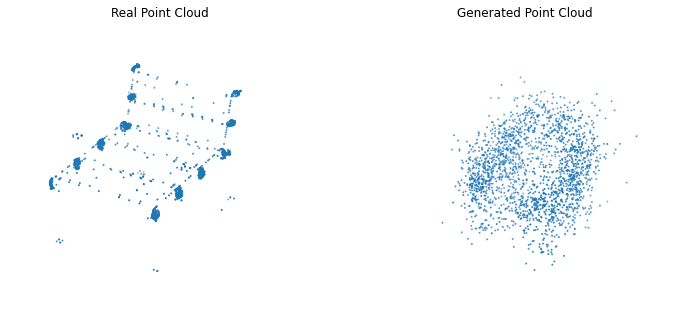

Saved final sample
Error in final generation: name 'generator' is not defined

Training completed successfully!
Cleanup complete


In [ ]:
if __name__ == "__main__":
    # Create necessary directories
    os.makedirs("results", exist_ok=True)
    os.makedirs("samples", exist_ok=True)
    
    try:
        train_point_cloud_gan()
    except KeyboardInterrupt:
        print("\nTraining manually stopped")
    except Exception as e:
        print(f"\nFatal error in main execution: {type(e).__name__}")
        print(f"Error message: {str(e)}")
        traceback.print_exc()
    finally:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("Cleanup complete")
        #tq3

 Analysis Functions

In [49]:
def analyze_results(run_dir='results'):
    """Analyze and visualize training results"""
    # 1. Plot training curves
    plot_training_curves(run_dir)
    
    # 2. Generate interpolation video
    create_interpolation_video(generator, latent_dim)
    
    # 3. Create HTML visualization
    generate_html_viewer(run_dir)

def plot_training_curves(run_dir):
    """Plot loss and metric curves"""
    # Implement reading from log files and plotting
    pass

def create_interpolation_video(generator, latent_dim, num_frames=60):
    """Create interpolation between random points in latent space"""
    z1 = torch.randn(1, latent_dim)
    z2 = torch.randn(1, latent_dim)
    
    os.makedirs('interpolation', exist_ok=True)
    
    for i in range(num_frames):
        alpha = i / num_frames
        z = alpha * z1 + (1-alpha) * z2
        pc = generator(z).cpu().numpy()[0]
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=1)
        plt.savefig(f'interpolation/frame_{i:03d}.png')
        plt.close()
    
    # Use ffmpeg to create video
    os.system('ffmpeg -r 30 -i interpolation/frame_%03d.png -vcodec libx264 -crf 25 interpolation.mp4')

def generate_html_viewer(run_dir):
    """Create simple HTML viewer for generated samples"""
    html_content = """
    <html>
    <head>
        <title>3D GAN Results</title>
        <style>
            .sample-container { display: flex; flex-wrap: wrap; }
            .sample { margin: 10px; text-align: center; }
            img { max-width: 300px; }
        </style>
    </head>
    <body>
        <h1>Generated 3D Samples</h1>
        <div class="sample-container">
    """
    
    # Find all sample images
    sample_files = [f for f in os.listdir('samples') if f.endswith('.png')]
    
    for sample in sample_files:
        base_name = sample.replace('.png', '')
        html_content += f"""
        <div class="sample">
            <h3>{base_name}</h3>
            <img src="samples/{sample}" alt="{base_name}">
            <p><a href="samples/{base_name}.ply">Download PLY</a></p>
        </div>
        """
    
    html_content += """
        </div>
    </body>
    </html>
    """
    
    with open(f'{run_dir}/viewer.html', 'w') as f:
        f.write(html_content)
    print(f"Created HTML viewer at {run_dir}/viewer.html")